# Regressão logística com Python

Para esta aula, estaremos trabalhando com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning!

Vamos tentar montar um algoritmo de classificação sobrevivente ou falecido utilizando regressão logística no Python.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Os dados

Vamos começar lendo o arquivo titanic_train.csv em um DataFrame pandas.

In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Análise de dados exploratórios

Vamos começar algumas análises de dados exploratórios. Começaremos por verificar os dados que faltam!

## Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados!

<Axes: >

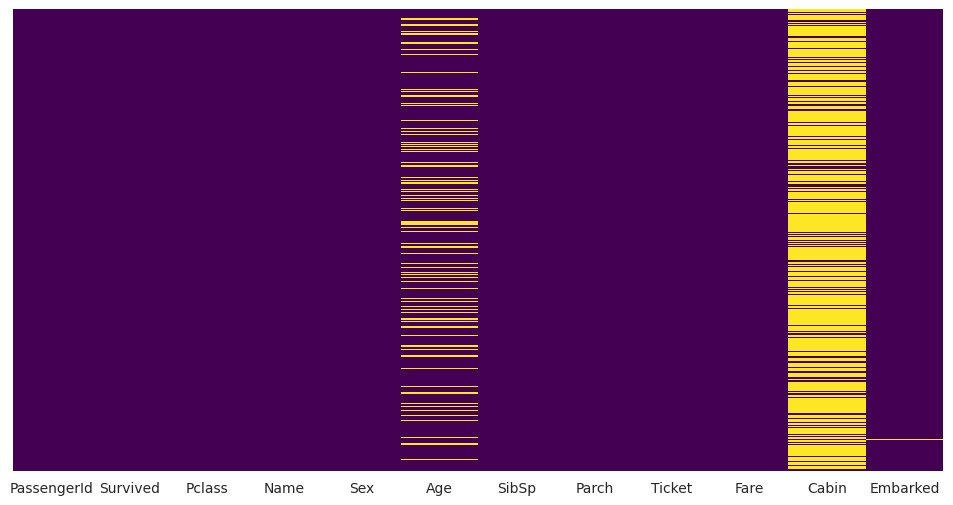

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')


Aproximadamente 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar isso mais tarde ou mudá-lo para outro "Cabin Conhecido: 1 ou 0"

Continuemos visualizando mais alguns dos dados! Confira o vídeo para obter explicações completas sobre esses gráficos, este código é apenas para servir como referência.

<Axes: xlabel='Survived', ylabel='count'>

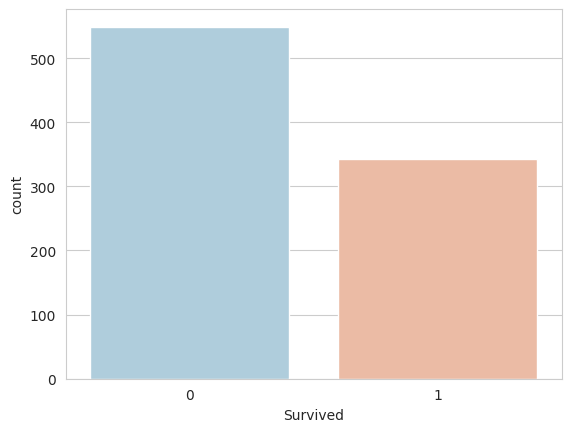

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

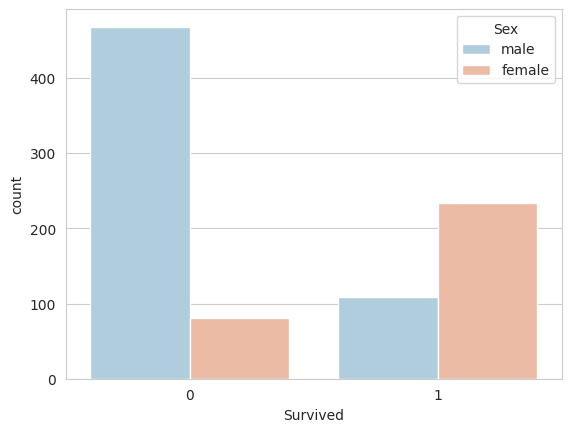

In [19]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

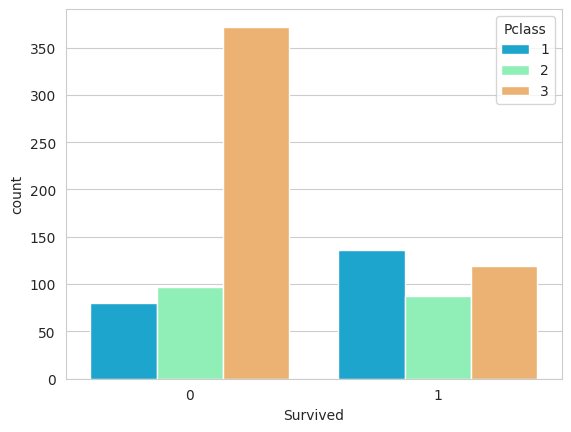

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: >

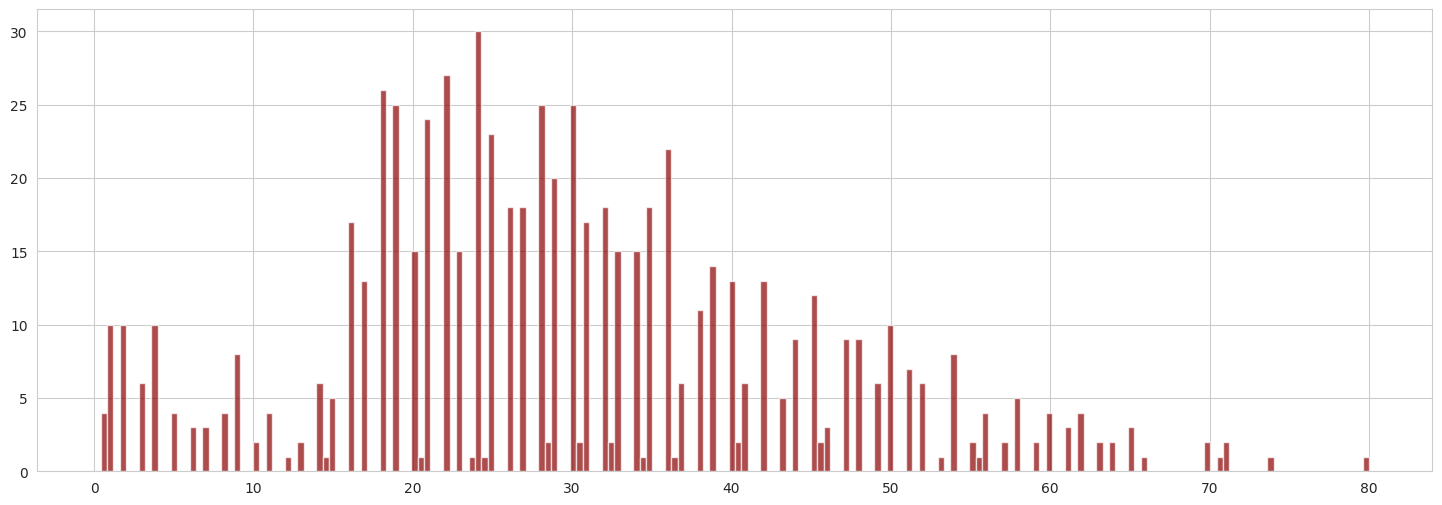

In [35]:
plt.figure(figsize=(18,6))
train['Age'].hist(bins=200,color='darkred',alpha=0.7)

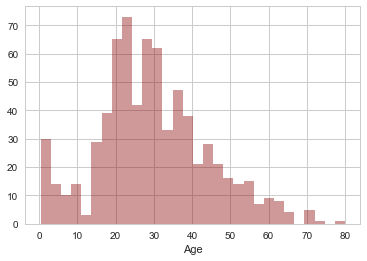

In [10]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

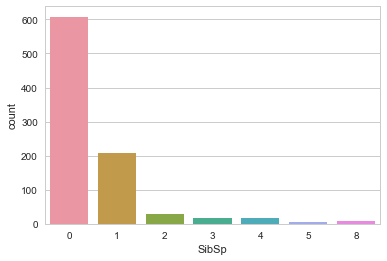

In [11]:
sns.countplot(x='SibSp',data=train)

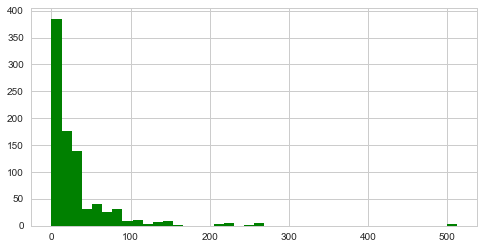

In [12]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Por exemplo:


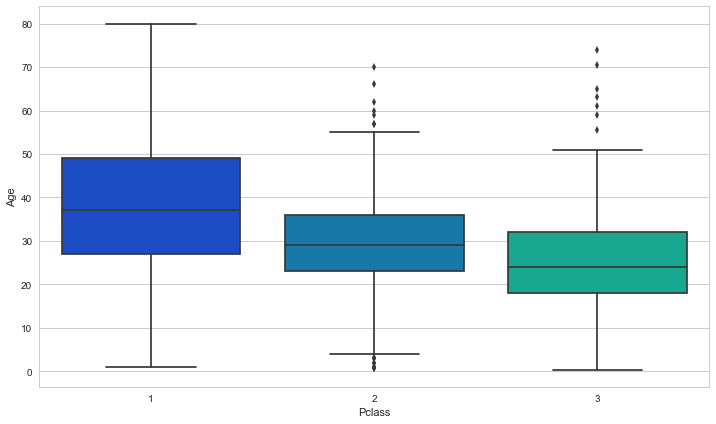

In [13]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver os passageiros mais ricos nas (que estão nas classes superiores) tendem a ser mais velhos, o que faz sentido. Usaremos esses valores de idade média para imputar com base em Pclass for Age.

In [14]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Agora aplique essa função!

In [15]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Agora vamos verificar esse mapa de calor novamente!

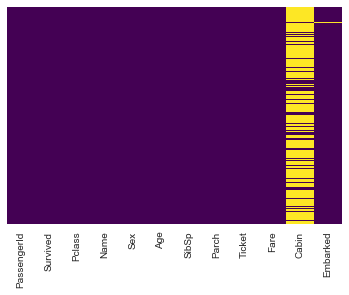

In [16]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ótimo! Vamos seguir em frente e deletar a coluna Cabin e a linha em Embarked que falta dado.

In [17]:
train.drop('Cabin',axis=1,inplace=True)

In [91]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [92]:
train.dropna(inplace=True)

## Convertendo recursos categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [19]:
sex = pd.get_dummies(train['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinaridade
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [20]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [21]:
train = pd.concat([train,sex,embark],axis=1)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Ótimo! Nossos dados estão prontos para o nosso modelo

# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

## Divisão treino-teste

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
predictions = logmodel.predict(X_test)

Vamos seguir em frente para avaliar o nosso modelo!

## Avaliação

Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.77      0.88      0.82       154
          1       0.79      0.64      0.71       114

avg / total       0.78      0.78      0.77       268



Não foi tão ruim! Você pode querer explorar outros recursos no outro arquivo titanic_text.csv. Algumas sugestões:

* Tente pegar o título (Dr., Sr., Sra., Etc.) do nome como parâmetro.
* Talvez a cabine possa ser uma característica.
* Existe alguma informação que você pode obter do bilhete?